In [1]:
from sklearn.preprocessing import StandardScaler
from hmmlearn.hmm import GaussianHMM
import numpy as np
import numpy as np
from matplotlib import cm, pyplot as plt
import seaborn as sns
import matplotlib.dates as mdates


In [2]:
stocks=['aapl','googl','nvda','dal','xom','cvx','vz']

In [3]:
import pandas as pd
import os
init_dir_path = str(os.getcwd())  # find current working directory
stock_paths=[init_dir_path+'/stock_data/'+x+'_prices.csv' for x in stocks]

In [4]:
features=['Return','Volatility','HighR','LowR']


In [29]:
data_full=[]
for sp,sn in zip(stock_paths,stocks):
    s=pd.read_csv(sp)
    #s=s.drop(['High','Low','Volume'],axis=1)
    s['Return']=100*(s['Close']-s['Open'])/s['Open']
    s['HighR']=100*(s['High']-s['Open'])/s['Open']
    s['LowR']=100*(s['Low']-s['Open'])/s['Open']
    s['Volatility']=s['Return'].rolling(window=3).std()
    s['Date']=pd.to_datetime(s['Date'])
    s=s.iloc[3:]
    s=s.reset_index(drop=True)
    #s[features]=StandardScaler().fit_transform(s[features])
    s['Ticker']=sn
    data_full.append(s)

In [46]:
data_with_date=[x[features+["Date"]] for x in data_full]
data = [x[features] for x in data_full]

In [31]:
def plot_in_sample_hidden_states(df):
    hidden_states = df['State']
    # Create the correctly formatted plot
    fig, ax = plt.subplots()
    state_colors = {0: 'green', 1: 'red'}

    for state, color in state_colors.items():
        mask = hidden_states == state
        ax.plot(
            df.index[mask],
            df["Close"][mask],
            ".", linestyle='none',
            c=color,
            label=f"State {state}"
        )
# Format x-axis with years
    ax.xaxis.set_major_locator(mdates.YearLocator())      # one tick per year
    ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y'))  # format tick labels as YYYY
    fig.autofmt_xdate()  # Rotate labels automatically

    ax.set_title("In-Sample Hidden States")
    ax.set_xlabel("Year")
    ax.set_ylabel("Close Price")
    ax.grid(True)
    ax.legend()
    plt.tight_layout()
    plt.show()

Train a different HMM for each stock

In [32]:
models=[]
for x in data_full:
    modl=GaussianHMM(n_components=2,n_iter=10000,tol=1e-5)
    modl.fit(x[features])
    models.append(modl)

Make regime predictions using trained models. We set State 0 to be bullish as convention.

In [33]:
def regime(state_info):
    return state_info[1] #returns volatility for now

In [49]:
l=[] #stores the mean feature values across stocks
for (i,x) in enumerate(data):
    x['State']=pd.Series(models[i].predict(x[features]))
    state_0 = x[x['State']==0].mean()
    state_1 = x[x['State']==1].mean()
    l.append((state_0,state_1))
    [a,b]  = list(map(regime, [state_0,state_1]))
    if a > b:
        x['State']=1-x['State']
    x['Ticker']=stocks[i]
    data_full[i]["State"]=x["State"]


C:\Users\18585\AppData\Local\Temp\ipykernel_26644\583023371.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  x['State']=pd.Series(models[i].predict(x[features]))
C:\Users\18585\AppData\Local\Temp\ipykernel_26644\1422317770.py:2: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  return state_info[1] #returns volatility for now
C:\Users\18585\AppData\Local\Temp\ipykernel_26644\583023371.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the do

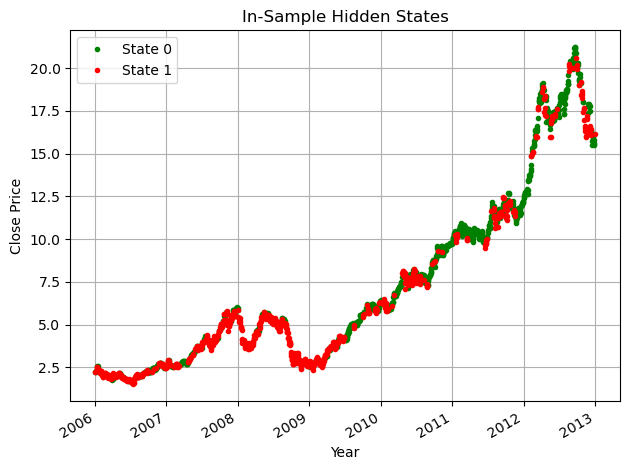

Plot for aapl


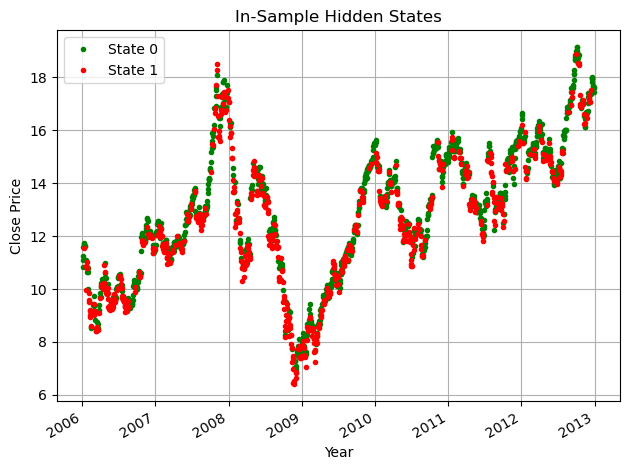

Plot for googl


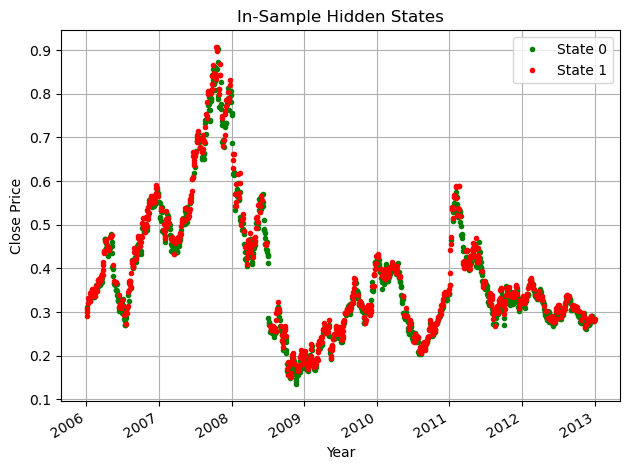

Plot for nvda


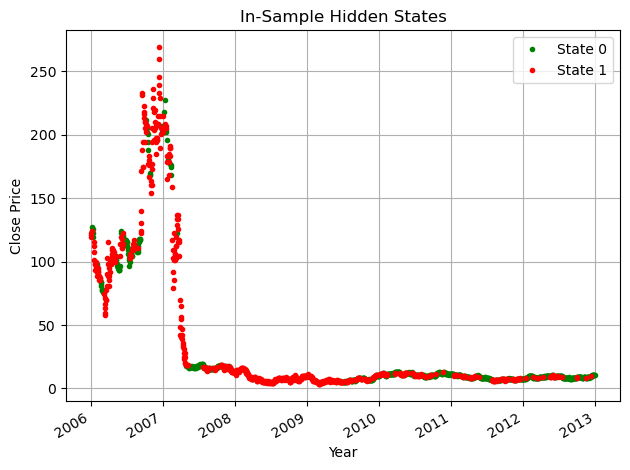

Plot for dal


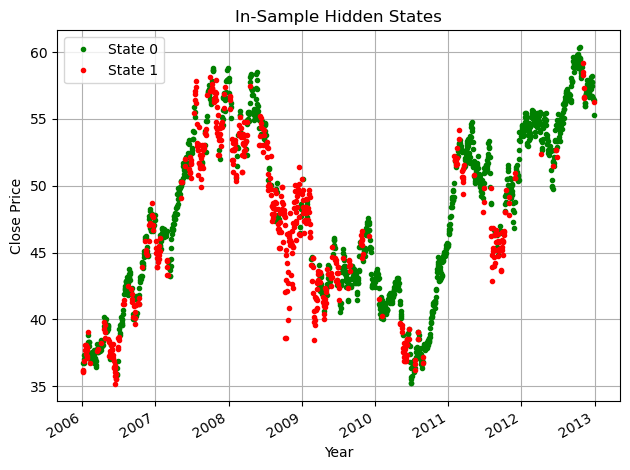

Plot for xom


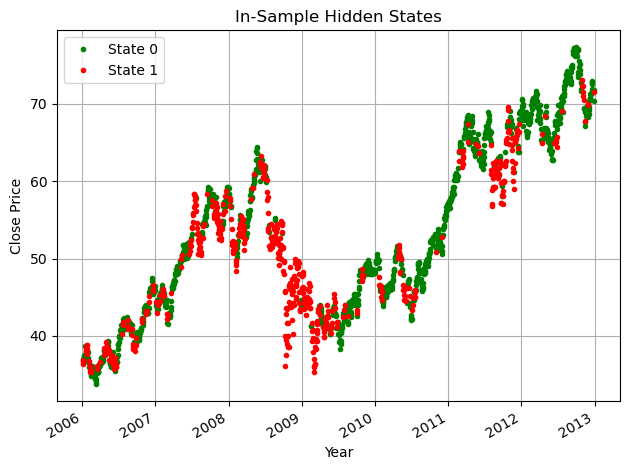

Plot for cvx


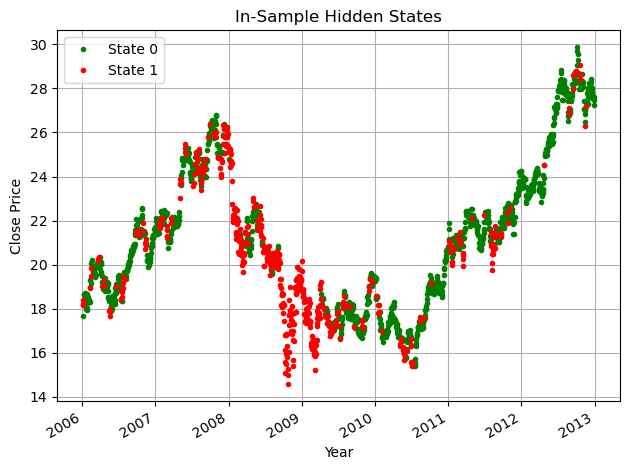

Plot for vz


In [51]:
for i in range(len(stocks)):
    stock = data_full[i]
    df= stock[stock["Date"].dt.year.isin(range(2006,2013))].reset_index(drop=True)
    df.set_index('Date', inplace=True)
    plot_in_sample_hidden_states(df)
    print(f"Plot for {stocks[i]}")

In [ ]:
#State 1 is bear, State 0 is bullish
#checking consistency
l

[(Return        0.083137
  Volatility    0.880444
  HighR         0.876253
  LowR         -0.823751
  State         0.000000
  dtype: float64,
  Return       -0.025391
  Volatility    2.370046
  HighR         1.833193
  LowR         -1.969716
  State         1.000000
  dtype: float64),
 (Return       -1.415469
  Volatility    1.515150
  HighR         0.488936
  LowR         -2.229707
  State         0.000000
  dtype: float64,
  Return        0.684266
  Volatility    1.085794
  HighR         1.332289
  LowR         -0.537528
  State         1.000000
  dtype: float64),
 (Return       -1.477737
  Volatility    2.022292
  HighR         0.862056
  LowR         -2.674778
  State         0.000000
  dtype: float64,
  Return        2.276566
  Volatility    2.479179
  HighR         3.461157
  LowR         -0.770241
  State         1.000000
  dtype: float64),
 (Return       -0.409711
  Volatility    4.722184
  HighR         3.821297
  LowR         -4.575271
  State         0.000000
  dtype: float

In [53]:
total=pd.concat(data_with_date).reset_index(drop=True)
total.to_csv('stock_hmm_output.csv')